<a href="https://colab.research.google.com/github/Nahom32/Evolutionary-Connectionst-Experiment/blob/main/notebooks/fedProxMetaheuristics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import copy
import random
from torch.utils.data import Subset, DataLoader

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLIENTS = 10         # Total available clients
CLIENTS_PER_ROUND = 5    # How many we want to select
NUM_ROUNDS = 5           # FL Rounds (Keep low for demo)
EPOCHS_PER_ROUND = 1     # Local training epochs
print(f"Setting up FedProx Simulation on {DEVICE}...")

Setting up FedProx Simulation on cuda...


In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
def get_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Create Non-IID chunks (sorted by label)
    labels = trainset.targets.numpy()
    sorted_idxs = np.argsort(labels)
    chunk_size = len(trainset) // NUM_CLIENTS
    client_datasets = [Subset(trainset, sorted_idxs[i*chunk_size:(i+1)*chunk_size]) for i in range(NUM_CLIENTS)]

    return client_datasets, testset

client_data, server_test_data = get_data()
test_loader = DataLoader(server_test_data, batch_size=256, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.08MB/s]


In [5]:
def train_client(global_model, dataset, mu=0.1):
    """Trains a client and returns the weights (state_dict)."""
    model = copy.deepcopy(global_model).to(DEVICE)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Store global parameters for Proximal term calculation
    global_params = [p.detach().clone() for p in global_model.parameters()]

    for _ in range(EPOCHS_PER_ROUND):
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)

            # FedProx Term: (mu / 2) * ||w - w_t||^2
            prox_term = 0.0
            for w, w_t in zip(model.parameters(), global_params):
                prox_term += (w - w_t).norm(2)**2
            loss += (mu / 2) * prox_term

            loss.backward()
            optimizer.step()

    return model.state_dict()

In [6]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    return correct / len(loader.dataset)

In [7]:
def aggregate_models(global_model, client_states, selected_indices):
    """Averages the weights of the selected clients."""
    if not selected_indices: return global_model.state_dict()

    avg_state = copy.deepcopy(global_model.state_dict())

    for key in avg_state.keys():
        # Stack weights from selected clients
        weights = [client_states[i][key] for i in selected_indices]
        # Average them
        avg_state[key] = torch.stack(weights).mean(dim=0)

    return avg_state

In [8]:
def get_fitness(selected_mask, global_model, client_states):
    # Convert binary mask [1, 0, 1...] to indices [0, 2...]
    indices = [i for i, x in enumerate(selected_mask) if x >= 0.5]

    # Constraint: If no client selected, fitness is 0
    if len(indices) == 0: return 0.0

    # 1. Aggregate
    new_weights = aggregate_models(global_model, client_states, indices)

    # 2. Evaluate (Fast evaluation on test set)
    temp_model = SimpleNet().to(DEVICE)
    temp_model.load_state_dict(new_weights)
    acc = evaluate(temp_model, test_loader)

    return acc

In [9]:
def run_sa(global_model, client_states):
    # Start with random selection
    current_mask = np.random.randint(0, 2, NUM_CLIENTS)
    current_fit = get_fitness(current_mask, global_model, client_states)

    best_mask = current_mask.copy()
    best_fit = current_fit

    T = 1.0
    alpha = 0.9  # Fast cooling for demo

    for i in range(50): # 50 Iterations
        # Flip one bit
        neighbor = current_mask.copy()
        idx = np.random.randint(0, NUM_CLIENTS)
        neighbor[idx] = 1 - neighbor[idx]

        neighbor_fit = get_fitness(neighbor, global_model, client_states)

        # Accept?
        if neighbor_fit > current_fit or np.random.rand() < np.exp((neighbor_fit - current_fit) / T):
            current_mask = neighbor
            current_fit = neighbor_fit
            if current_fit > best_fit:
                best_fit = current_fit
                best_mask = current_mask.copy()

        T *= alpha

    return [i for i, x in enumerate(best_mask) if x == 1]

In [10]:
# --- Algorithm 2: Particle Swarm (Binary PSO) ---
def run_pso(global_model, client_states):
    num_particles = 10
    dim = NUM_CLIENTS
    # Positions (Log-odds), Velocities
    pos = np.random.uniform(-1, 1, (num_particles, dim))
    vel = np.zeros_like(pos)
    pbest_pos = pos.copy()
    pbest_val = np.zeros(num_particles)
    gbest_pos = pos[0].copy()
    gbest_val = 0.0

    for i in range(30): # 30 Iterations
        for p in range(num_particles):
            # Sigmoid to get binary mask
            mask = (1 / (1 + np.exp(-pos[p]))) > 0.5
            fit = get_fitness(mask, global_model, client_states)

            if fit > pbest_val[p]:
                pbest_val[p] = fit
                pbest_pos[p] = pos[p].copy()

            if fit > gbest_val:
                gbest_val = fit
                gbest_pos = pos[p].copy()

            # Update Velocity & Position
            r1, r2 = np.random.rand(), np.random.rand()
            vel[p] = 0.5*vel[p] + 1.5*r1*(pbest_pos[p]-pos[p]) + 1.5*r2*(gbest_pos - pos[p])
            pos[p] += vel[p]

    final_mask = (1 / (1 + np.exp(-gbest_pos))) > 0.5
    return [i for i, x in enumerate(final_mask) if x]

In [11]:
# --- Algorithm 3: Genetic Algorithm ---
def run_ga(global_model, client_states):
    pop_size = 10
    pop = np.random.randint(0, 2, (pop_size, NUM_CLIENTS))

    for gen in range(20): # 20 Generations
        # Evaluate
        fitnesses = [get_fitness(ind, global_model, client_states) for ind in pop]

        # Select best parent
        best_idx = np.argmax(fitnesses)
        best_ind = pop[best_idx]

        # Simple Evolution: Elitism + Random Mutation
        new_pop = [best_ind.copy()] # Keep best
        while len(new_pop) < pop_size:
            # Mutate the best solution slightly to create children
            child = best_ind.copy()
            mutation_point = np.random.randint(0, NUM_CLIENTS)
            child[mutation_point] = 1 - child[mutation_point]
            new_pop.append(child)
        pop = np.array(new_pop)

    final_best = pop[0]
    return [i for i, x in enumerate(final_best) if x == 1]

In [12]:


results = {"Baseline": [], "SA": [], "PSO": [], "GA": []}

# Initialize one global model for each strategy to keep them separate
models = {
    "Baseline": SimpleNet().to(DEVICE),
    "SA": SimpleNet().to(DEVICE),
    "PSO": SimpleNet().to(DEVICE),
    "GA": SimpleNet().to(DEVICE)
}

print("\nStarting Tournament...")

for round_idx in range(NUM_ROUNDS):
    print(f"\n--- Round {round_idx + 1}/{NUM_ROUNDS} ---")

    # 1. Pre-calculate Client Updates (The "Cache")
    # In a real sim, we do this once per round base on the 'Baseline' model state
    # (assuming all start from roughly same place for fair comparison in this step)
    # OR, strictly, each strategy has diverged.
    # To be accurate: We must train clients SPECIFICALLY for each model.

    for strategy_name in models.keys():
        print(f"Processing {strategy_name}...", end=" ")
        global_model = models[strategy_name]

        # Train ALL clients starting from this strategy's current model
        # (This is the expensive part, we do it for everyone to see who picks best)
        client_states = []
        for i in range(NUM_CLIENTS):
            w_local = train_client(global_model, client_data[i])
            client_states.append(w_local)

        # 2. Select Clients
        if strategy_name == "Baseline":
            # Random selection
            selected = random.sample(range(NUM_CLIENTS), CLIENTS_PER_ROUND)
        elif strategy_name == "SA":
            selected = run_sa(global_model, client_states)
        elif strategy_name == "PSO":
            selected = run_pso(global_model, client_states)
        elif strategy_name == "GA":
            selected = run_ga(global_model, client_states)

        # Force at least 1 client if algos return empty
        if not selected: selected = [0]

        # 3. Aggregation
        new_weights = aggregate_models(global_model, client_states, selected)
        global_model.load_state_dict(new_weights)

        # 4. Record Performance
        acc = evaluate(global_model, test_loader)
        results[strategy_name].append(acc)
        print(f"Selected {len(selected)} clients -> Acc: {acc:.4f}")

# Display Final Summary
print("\n Final Results (Accuracy per Round):")
import pandas as pd
df = pd.DataFrame(results)
print(df)
df.to_csv("fedprox_results.csv")


Starting Tournament...

--- Round 1/5 ---
Processing Baseline... Selected 5 clients -> Acc: 0.3536
Processing SA... Selected 7 clients -> Acc: 0.4163
Processing PSO... Selected 5 clients -> Acc: 0.4050
Processing GA... Selected 7 clients -> Acc: 0.4194

--- Round 2/5 ---
Processing Baseline... Selected 5 clients -> Acc: 0.4214
Processing SA... Selected 6 clients -> Acc: 0.5339
Processing PSO... Selected 6 clients -> Acc: 0.4506
Processing GA... Selected 6 clients -> Acc: 0.5013

--- Round 3/5 ---
Processing Baseline... Selected 5 clients -> Acc: 0.4799
Processing SA... Selected 6 clients -> Acc: 0.5952
Processing PSO... Selected 7 clients -> Acc: 0.5321
Processing GA... Selected 9 clients -> Acc: 0.5317

--- Round 4/5 ---
Processing Baseline... Selected 5 clients -> Acc: 0.4188
Processing SA... Selected 5 clients -> Acc: 0.6616
Processing PSO... Selected 5 clients -> Acc: 0.5944
Processing GA... Selected 5 clients -> Acc: 0.5979

--- Round 5/5 ---
Processing Baseline... Selected 5 cli

Plot saved to 'convergence_plot.png'


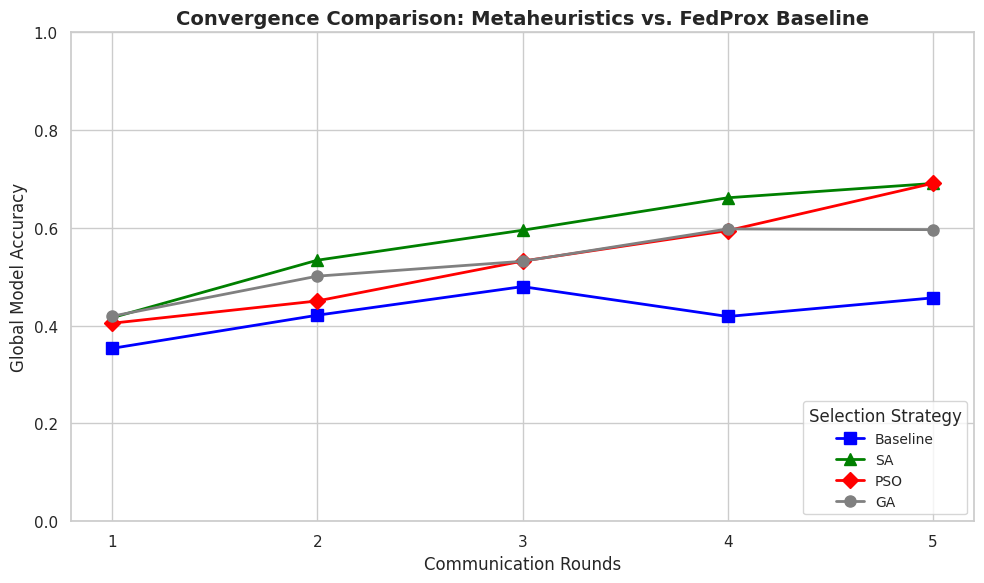

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_benchmark_results(csv_path="fedprox_results.csv"):
    # 1. Load Data
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print("Error: CSV file not found. Please run the experiment loop first!")
        return

    # 2. Setup Plot Style
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # 3. Plot each strategy
    # The Index represents the 'Round', Columns are the Strategies
    markers = ['o', 's', '^', 'D'] # Circle, Square, Triangle, Diamond
    colors = ['gray', 'blue', 'green', 'red']

    for idx, column in enumerate(df.columns):
        if column == 'Unnamed: 0':
            continue
        plt.plot(
            df.index + 1,          # X-axis: Round Number (1-based)
            df[column],            # Y-axis: Accuracy
            label=column,
            marker=markers[idx % len(markers)],
            color=colors[idx % len(colors)],
            linewidth=2,
            markersize=8
        )

    # 4. Formatting for Academic Paper
    plt.title("Convergence Comparison: Metaheuristics vs. FedProx Baseline", fontsize=14, fontweight='bold')
    plt.xlabel("Communication Rounds", fontsize=12)
    plt.ylabel("Global Model Accuracy", fontsize=12)
    plt.legend(title="Selection Strategy", fontsize=10, loc='lower right')
    plt.xticks(range(1, len(df) + 1)) # Force integer ticks for rounds
    plt.ylim(0, 1.0) # Accuracy is 0-1

    # 5. Save & Show
    plt.tight_layout()
    plt.savefig("convergence_plot.png", dpi=300) # High-res for your paper
    print("Plot saved to 'convergence_plot.png'")
    plt.show()

# Run the plotter
plot_benchmark_results()